# Tarea 2 - Sistema de recomendación
## Inteligencia de negocios

### Bibliotecas usadas

In [1]:
import pandas as pd
from dotenv import load_dotenv
import requests
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.sparse as sparse
plt.rcParams["figure.figsize"] = (12,10)

load_dotenv()

True

### Carga de datos y preprocesamiento

#### Lectura de los archivos

In [2]:
movie_titles = pd.read_csv("movie_titles.csv", usecols=range(3), names=['id', 'year', 'name'], encoding='ISO-8859-1')
movie_titles

,id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [3]:

#ratings_folder = 'c:\\umayor\\training_set'
#files = ['\\mv_{}.txt'.format(str(f).zfill(7)) for f in range(1,17771)]
#movie_ratings = pd.DataFrame(columns = ['movie', 'user', 'rating', 'date'])
#df_list = []
#
#for filename in tqdm(files):
#    temp = pd.read_csv(ratings_folder + filename, names = ['user', 'rating', 'date'], skiprows = 1)
#    temp['movie'] = filename.split('.')[0].split('_')[1].lstrip('0')
#    df_list.append(temp)
#
#movie_ratings = pd.concat(df_list).loc[:, ['movie', 'user', 'rating', 'date']]
#movie_ratings = movie_ratings.astype({'movie': np.int32, 'user': np.int32, 'rating': np.int32})
#movie_ratings


In [12]:

ratings_folder = 'c:\\umayor\\training_set'
files = ['\\mv_{}.txt'.format(str(f).zfill(7)) for f in range(1,17771)]
df_list = []

for filename in tqdm(files[:500]):
    temp = pd.read_csv(ratings_folder + filename, names = ['user', 'rating', 'date'], skiprows = 1)
    temp['movie'] = filename.split('.')[0].split('_')[1].lstrip('0')

    interactions = (temp.groupby(['user', 'movie'])['rating']
      .sum()
      .unstack()
      .reset_index()
      .fillna(0)
      .set_index('user')
    )
    #print (interactions.shape)
    df_list.append(interactions)
pivot_df = pd.DataFrame()
pivot_df = pivot_df.append(df_list, sort=False)
pivot_df = pivot_df.fillna(0)
pivot_df

100%|██████████| 500/500 [00:02<00:00, 176.83it/s]


movie,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
user,,,,,,,,,,,,,,,,,,,,,
915,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2442,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3321,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4326,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11589,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2615660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2625420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [13]:
#
#ratings_folder = 'c:\\umayor\\training_set'
#files = ['\\mv_{}.txt'.format(str(f).zfill(7)) for f in range(1,17771)]
#
#pivot_df = pd.DataFrame()
#for filename in tqdm(files[:500]):
    #temp = pd.read_csv(ratings_folder + filename, names = ['user', 'rating', 'date'], skiprows = 1)
    #temp['movie'] = filename.split('.')[0].split('_')[1].lstrip('0')
#
    #interactions = (temp.groupby(['user', 'movie'])['rating']
      #.sum()
      #.unstack()
      #.reset_index()
      #.fillna(0)
      #.set_index('user')
    #)
    ##print (interactions.shape)
    #pivot_df = pivot_df.append(interactions, sort=False) 

In [14]:
from scipy import sparse
import numpy as np
from lightfm.cross_validation import random_train_test_split
sparse_matrix = sparse.csr_matrix(pivot_df.to_numpy())
train_test = random_train_test_split(sparse_matrix, test_percentage=0.2)
train = train_test[0]
test = train_test[1]

C:\Users\Melissa\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [15]:
from lightfm import LightFM
model = LightFM(loss='warp')
model.fit(train, epochs=30, num_threads=12)

https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model/45466481#45466481

In [20]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
train_precision = precision_at_k(model, train, k=5).mean()
test_precision = precision_at_k(model, train, test, k=5).mean()
train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

In [21]:
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.20, test 0.20.
AUC: train 1.00, test 0.88.


#### Identificación y corrección de columnas vacías

In [4]:
print("----- Campos NaN en columna id -----\n", movie_titles[movie_titles['name'].isna()])
print("----- Campos NaN en columna año -----\n", movie_titles[movie_titles['year'].isna()])
print("----- Campos NaN en columna nombre -----\n", movie_titles[movie_titles['id'].isna()])

----- Campos NaN en columna id -----
 Empty DataFrame
Columns: [id, year, name]
Index: []
----- Campos NaN en columna año -----
           id  year                                         name
4387    4388   NaN      Ancient Civilizations: Rome and Pompeii
4793    4794   NaN  Ancient Civilizations: Land of the Pharaohs
7240    7241   NaN     Ancient Civilizations: Athens and Greece
10781  10782   NaN                       Roti Kapada Aur Makaan
15917  15918   NaN                      Hote Hote Pyaar Ho Gaya
16677  16678   NaN                              Jimmy Hollywood
17666  17667   NaN                           Eros Dance Dhamaka
----- Campos NaN en columna nombre -----
 Empty DataFrame
Columns: [id, year, name]
Index: []


#### Llenado de la información faltante
Para no tener que eliminar estas películas, primero probamos la API de The Movie Database, en caso de que esta pudiera entregarnos los años de cada película.

In [5]:
api_key = os.getenv("API_KEY")

for movie in movie_titles[movie_titles['year'].isna()]['name']:
    url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={movie}"
    response = requests.get(url)
    data = response.json()
    try:
        relase_date = data['results'][0]['release_date']
        if relase_date == '':
            raise
        release_year = relase_date[:4]
        print("🟢 La fecha de lanzamiento de " + movie + " es " + relase_date + ", del año " + release_year + ".")
        movie_titles.loc[movie_titles['name'] == movie, 'year'] = release_year
    except: print("🔴 No se encontró fecha de lanzamiento para " + movie + ".")

🔴 No se encontró fecha de lanzamiento para Ancient Civilizations: Rome and Pompeii.
🔴 No se encontró fecha de lanzamiento para Ancient Civilizations: Land of the Pharaohs.
🔴 No se encontró fecha de lanzamiento para Ancient Civilizations: Athens and Greece.
🟢 La fecha de lanzamiento de Roti Kapada Aur Makaan es 1974-01-01, del año 1974.
🔴 No se encontró fecha de lanzamiento para Hote Hote Pyaar Ho Gaya.
🟢 La fecha de lanzamiento de Jimmy Hollywood es 1994-03-30, del año 1994.
🔴 No se encontró fecha de lanzamiento para Eros Dance Dhamaka.


Ya que solo se encontró el año de lanzamiento de dos películas, se procede a hacer una búsqueda manual en Google para llenar las películas faltantes.

In [6]:
movie_titles.at[4387, 'year'] = 2001
movie_titles.at[4793, 'year'] = 2001
movie_titles.at[7240, 'year'] = 2002
movie_titles.at[15917, 'year'] = 1999
movie_titles.at[17666, 'year'] = 1999
movie_titles = movie_titles.astype(dtype = {'id': np.int32, 'year': np.int32})
print("----- Campos NaN en columna año -----\n", movie_titles[movie_titles['year'].isna()])

----- Campos NaN en columna año -----
 Empty DataFrame
Columns: [id, year, name]
Index: []


## Análisis

In [7]:
movie_titles['year'].describe()

count    17770.000000
mean      1990.265841
std         16.506002
min       1896.000000
25%       1985.000000
50%       1997.000000
75%       2002.000000
max       2005.000000
Name: year, dtype: float64

In [8]:
movie_ratings['rating'].describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

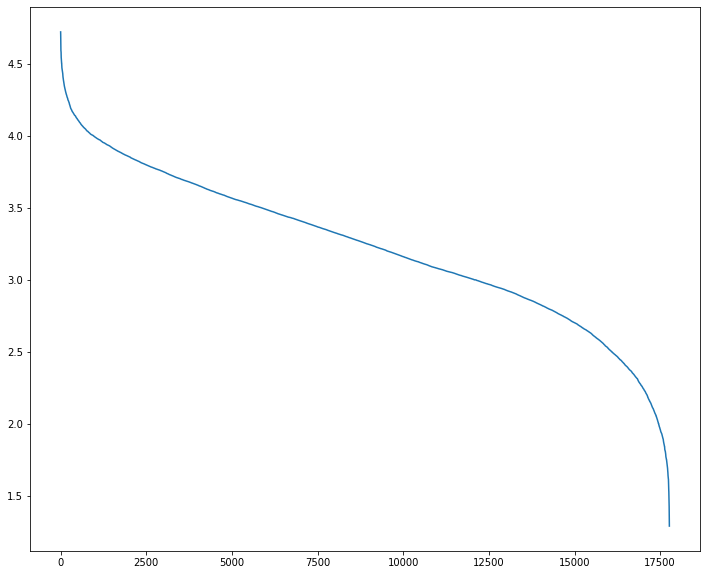

In [16]:
plt.plot(mean_ratings.sort_values(by='mean', ascending=False)['mean'].values)

(array([   7.,   13.,   35.,   84.,  148.,  207.,  287.,  425.,  586.,
         714., 1026., 1335., 1824., 1654., 1677., 1726., 1676., 1446.,
        1261.,  875.,  433.,  189.,   85.,   45.,   12.]),
 array([1.28787879, 1.42529443, 1.56271008, 1.70012572, 1.83754137,
        1.97495702, 2.11237266, 2.24978831, 2.38720395, 2.5246196 ,
        2.66203524, 2.79945089, 2.93686653, 3.07428218, 3.21169783,
        3.34911347, 3.48652912, 3.62394476, 3.76136041, 3.89877605,
        4.0361917 , 4.17360734, 4.31102299, 4.44843863, 4.58585428,
        4.72326993]),
 <BarContainer object of 25 artists>)

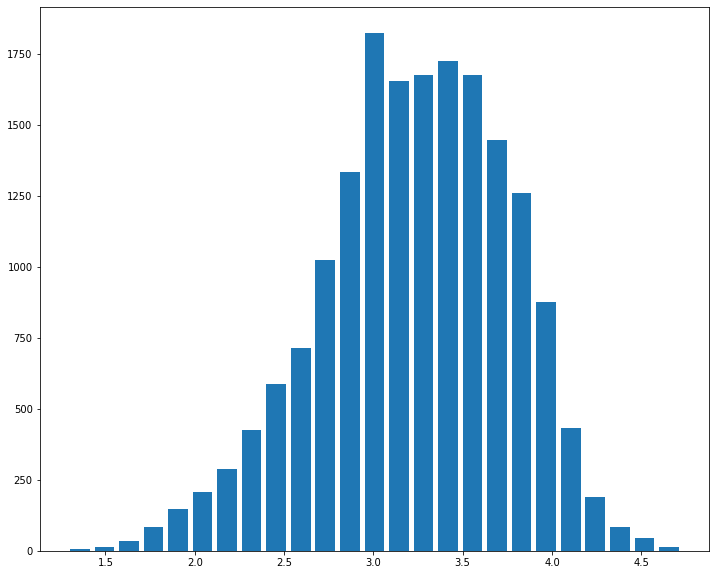

In [17]:
plt.hist(mean_ratings.sort_values(by='mean', ascending=False)['mean'].values, bins=25, rwidth=0.8)

Puntaje promedio de la película 1

In [10]:
movie_ratings[movie_ratings.movie == 1]['rating'].mean()

3.749542961608775

Lista de filas para la película 1

In [23]:
movie_ratings.loc[movie_ratings['movie'] == 1]

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
542,1,1790158,4,2005-05-17
543,1,1403184,3,2005-11-12
544,1,1535440,4,2005-08-18
545,1,1426604,4,2005-09-01


In [12]:
mean_ratings = movie_ratings.groupby('movie')['rating'].agg(['mean','count'])
mean_ratings

,mean,count
movie,,
1,3.749543,547
2,3.558621,145
3,3.641153,2012
4,2.739437,142
5,3.919298,1140
...,...,...
17766,3.193388,605
17767,3.671569,204
17768,2.839207,1362


In [13]:
mean_ratings.sort_values(by='mean', ascending=False).head(10)

,mean,count
movie,,
14961,4.723270,73335
7230,4.716611,73422
7057,4.702611,74912
3456,4.670989,7249
9864,4.638809,1747
15538,4.605021,1633
8964,4.600000,25
14791,4.600000,75
10464,4.595506,89


In [14]:
mean_ratings.sort_values(by=['count'], ascending=False).head(10)['mean']

movie
5317     3.361267
15124    3.724238
14313    3.783854
15205    3.442166
1905     4.153908
6287     3.905047
11283    4.299910
16377    4.306941
16242    3.454411
12470    3.411870
Name: mean, dtype: float64

In [15]:
data.size

AttributeError: 'dict' object has no attribute 'size'

In [ ]:
row = movie_ratings['user'].values
col = movie_ratings['movie'].values
data = movie_ratings['rating'].values
from scipy.sparse import csr_matrix
csr_matrix((data, (row, col)), shape=(100480507, 100480507)).toarray()

MemoryError: Unable to allocate 35.9 PiB for an array with shape (100480507, 100480507) and data type int32

In [ ]:
sorted_users = np.sort(movie_ratings['user'].unique())
sorted_movies = np.sort(movie_ratings['movie'].unique())
mean_normalization = []
for i in (range(sorted_movies.size)):
    for u in tqdm(range(sorted_users.size)):
        mean_normalization.append(movie_ratings[(movie_ratings['user'] == sorted_users[u]) & (movie_ratings['movie'] == sorted_movies[i])]['rating'].mean())
mean_normalization = np.array(mean_normalization)
mean_normalization


  0%|          | 24/480189 [00:06<36:13:29,  3.68it/s]


KeyboardInterrupt: 

In [ ]:
mean_normalization

<17770x2 sparse matrix of type '<class 'numpy.float64'>'
	with 35540 stored elements in Compressed Sparse Row format>

array([      6,       7,       8, ..., 2649421, 2649426, 2649429])

In [25]:
!pip install lightfm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for lightfm, since package 'wheel' is not installed.
    Running setup.py install for lightfm: started
    Running setup.py install for lightfm: finished with status 'done'


You should consider upgrading via the 'c:\users\melissa\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [26]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
model = LightFM(loss='warp')
model.fit(sparse_data, epochs=30, num_threads=16)
test_precision = precision_at_k(model, sparse_test_data, item_features=item_features_concat).mean()

C:\Users\Melissa\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [32]:
n = int(17770*0.8)
print(n)

14216


In [53]:
n

2648862

In [89]:
row = movie_ratings.iloc[:5000]['user'].values
col = movie_ratings[:5000]['movie'].values
data = movie_ratings[:5000]['rating'].values
n = max(max(row), max(col)) + 1
print(n)
sparse_data = sparse.coo_matrix((data, (row, col)), shape=(n, n))#.toarray()

2648862


In [90]:
model = LightFM(loss='warp')
model.fit(sparse_data, epochs=30, num_threads=16)


In [91]:
row_test = movie_ratings.iloc[5000:10000]['user'].values
col_test = movie_ratings[5000:10000]['movie'].values
data_test = movie_ratings[5000:10000]['rating'].values
n_test = max(max(row_test), max(col_test)) + 1
print(n_test)
sparse_test_data = sparse.coo_matrix((data_test, (row_test, col_test)), shape=(n_test, n_test))#.toarray()
sparse_test_data

2648205


<2648205x2648205 sparse matrix of type '<class 'numpy.int32'>'
	with 5000 stored elements in COOrdinate format>

In [121]:
import scipy as sp
sparse.csr_matrix(np.eye(movie_ratings[5000:10000].shape[0]))
eye = sparse.csr_matrix(sp.eye(data_test.shape[0], data_test.shape[0]))
item_features_concat = sparse.hstack((eye[0], data_test[0]))
item_features_concat = sparse.csr_matrix(item_features_concat).astype(np.float32)
print(item_features_concat)
test_precision = precision_at_k(model, sparse_test_data, item_features=item_features_concat).mean()

<ipython-input-121-f271e3c25e91>:3: DeprecationWarning: scipy.eye is deprecated and will be removed in SciPy 2.0.0, use numpy.eye instead
  eye = sparse.csr_matrix(sp.eye(data_test.shape[0], data_test.shape[0]))


  (0, 0)	1.0
  (0, 5000)	1.0


Exception: Number of item feature rows does not equal the number of items

ERROR: Could not find a version that satisfies the requirement maciejkula (from versions: none)
ERROR: No matching distribution found for maciejkula
You should consider upgrading via the 'c:\users\melissa\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [147]:
chunk_size = 50000
chunks = [x for x in range(0, movie_ratings.shape[0], chunk_size)]

for i in range(0, len(chunks) - 1):
    print(chunks[i], chunks[i + 1] - 1)

0 49999
50000 99999
100000 149999
150000 199999
200000 249999
250000 299999
300000 349999
350000 399999
400000 449999
450000 499999
500000 549999
550000 599999
600000 649999
650000 699999
700000 749999
750000 799999
800000 849999
850000 899999
900000 949999
950000 999999
1000000 1049999
1050000 1099999
1100000 1149999
1150000 1199999
1200000 1249999
1250000 1299999
1300000 1349999
1350000 1399999
1400000 1449999
1450000 1499999
1500000 1549999
1550000 1599999
1600000 1649999
1650000 1699999
1700000 1749999
1750000 1799999
1800000 1849999
1850000 1899999
1900000 1949999
1950000 1999999
2000000 2049999
2050000 2099999
2100000 2149999
2150000 2199999
2200000 2249999
2250000 2299999
2300000 2349999
2350000 2399999
2400000 2449999
2450000 2499999
2500000 2549999
2550000 2599999
2600000 2649999
2650000 2699999
2700000 2749999
2750000 2799999
2800000 2849999
2850000 2899999
2900000 2949999
2950000 2999999
3000000 3049999
3050000 3099999
3100000 3149999
3150000 3199999
3200000 3249999
3250000 

In [146]:
pivot_df = pd.DataFrame()
for i in tqdm(range(0, len(chunks) - 1)):
    chunk_df = movie_ratings.iloc[ chunks[i]:chunks[i + 1] - 1]
    interactions = (chunk_df.groupby(['user', 'movie'])['rating']
      .sum()
      .unstack()
      .reset_index()
      .fillna(0)
      .set_index('user')
    )
    #print (interactions.shape)
    pivot_df = pivot_df.append(interactions, sort=False) 

  5%|▌         | 10/200 [01:40<31:41, 10.01s/it]


KeyboardInterrupt: 

In [ ]:
from scipy import sparse
import numpy as np
sparse_matrix = sparse.csr_matrix(df_new.to_numpy())